In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from SyntheticDataModule import *
from estimators import *
from utils import *

Study index S: 0
Sample size n: 8000
Covariate dimensionality: 1
***
True ATE: 1.108
No-censoring naive ATE estimate: 1.118
Censoring-imputed ATE estimate: 0.979
Censoring-dropped ATE estimate: 0.982
***
Oracle IPW-estimated ATE: 1.126

Study index S: 1
Sample size n: 16000
Covariate dimensionality: 1
***
True ATE: 0.989
No-censoring naive ATE estimate: 0.900
Censoring-imputed ATE estimate: 0.759
Censoring-dropped ATE estimate: 0.777
***
Oracle IPW-estimated ATE: 0.972



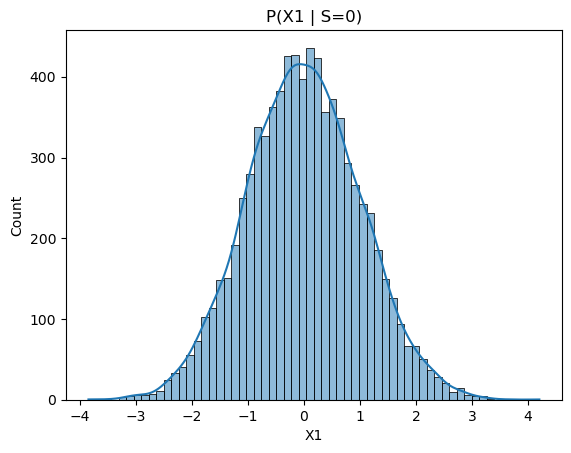

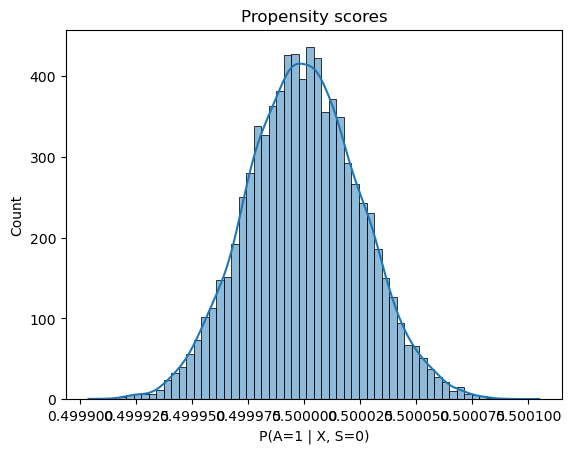

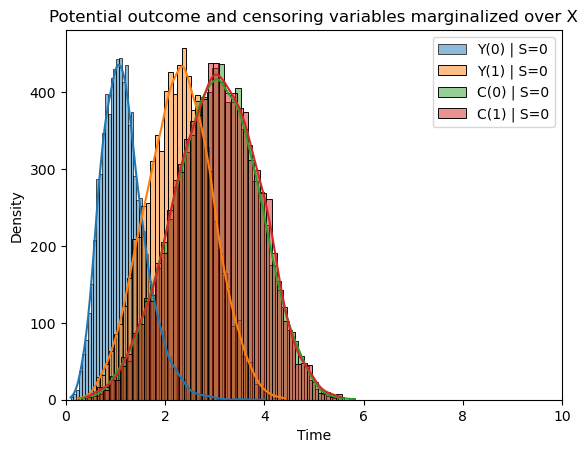

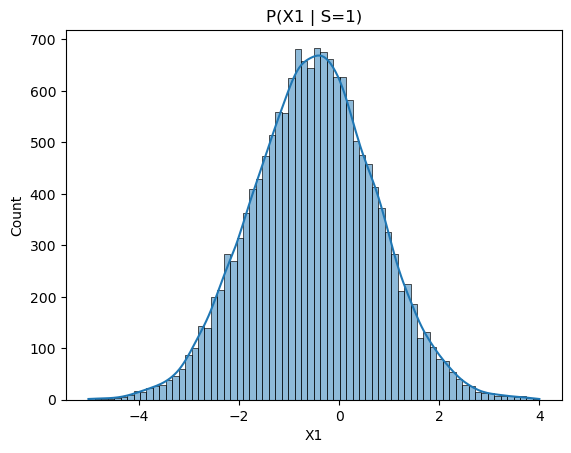

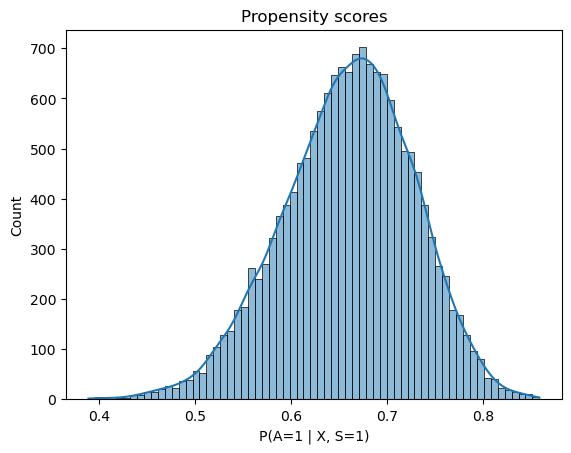

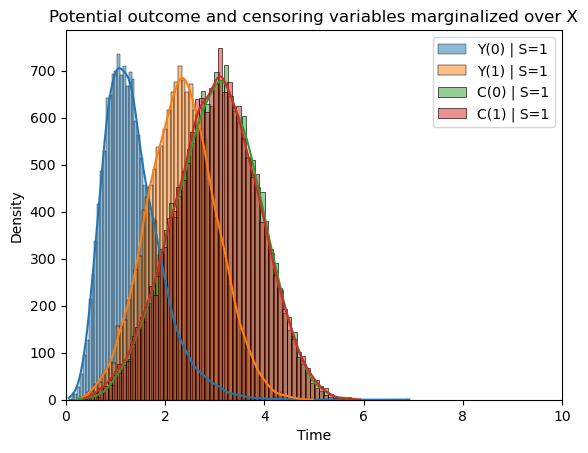

In [2]:
rct_size = 8000
m = 2
obs_size = rct_size * m

RCTData = SyntheticDataModule(save_df=True, d=1, n=rct_size, S=0,
                                px_dist='Gaussian', px_args={'mean': [0], 'cov': [[1]]},
                                prop_fn='sigmoid', prop_args={'beta': [0, 1e-4]},
                                tte_params = {'model': 'coxph',
                                                'hazard': 'weibull',
                                                'cox_args': {'Y0': {'beta': [0,1], 'lambda': 0.8, 'p': 4},
                                                            'Y1': {'beta': [0,0.25], 'lambda': 0.4, 'p': 4},
                                                            'C0': {'beta': [0,0], 'lambda': 0.3, 'p': 4},
                                                            'C1': {'beta': [0,0], 'lambda': 0.3, 'p': 4},},
                                            }
                    )

df_rct_oracle, df_rct = RCTData.get_df()
RCTData.summary()

OBSData = SyntheticDataModule(save_df=True, d=1, n=obs_size, S=1,
                                px_dist='Gaussian', px_args={'mean': [-0.5], 'cov': [[1.5]]},
                                prop_fn='sigmoid', prop_args={'beta': [0.8, 0.25]},
                                tte_params = {'model': 'coxph',
                                                'hazard': 'weibull',
                                                'cox_args': {'Y0': {'beta': [0,1], 'lambda': 0.8, 'p': 4},
                                                            'Y1': {'beta': [0,0.25], 'lambda': 0.4, 'p': 4},
                                                            'C0': {'beta': [0,0], 'lambda': 0.3, 'p': 4},
                                                            'C1': {'beta': [0,0], 'lambda': 0.3, 'p': 4},},
                                            }
                    )


df_obs_oracle, df_obs = OBSData.get_df()
OBSData.summary()

df_combined = pd.concat([df_rct, df_obs], axis=0, ignore_index=True)

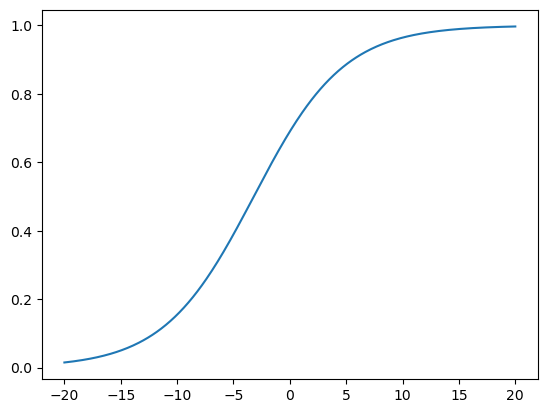

In [3]:
t = np.linspace(-20,20,401)
obs_oracle_prop = OBSData.calc_oracle_prop(t,'X1')
plt.plot(t, obs_oracle_prop)

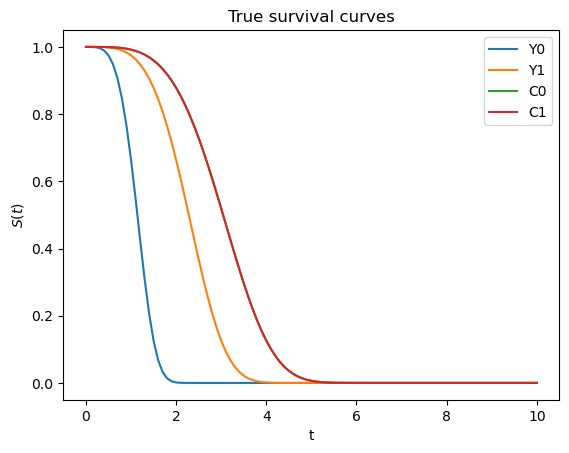

In [4]:
t2 = np.linspace(0,10,101)
tbs_Y0, tbs_Y1, tbs_C0, tbs_C1 = RCTData.calc_oracle_surv_curves(t2, [0, 0])
plt.figure()
plt.plot(t2, tbs_Y0, label='Y0')
plt.plot(t2, tbs_Y1, label='Y1')
plt.plot(t2, tbs_C0, label='C0')
plt.plot(t2, tbs_C1, label='C1')
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title('True survival curves')
plt.legend()
plt.show()

In [ ]:
df_combined['P(S_X)'], _, _ = prop_score_est(df_combined, 'S', RCTData.cov_list, 'logistic')

df_combined.loc[df_combined.S==0, 'P(A_XS)'], full_x_s0, full_pa_x_s0 = prop_score_est(df_combined.query('S==0'), 'A', RCTData.cov_list, 'mean', get_full_fn=True, interval=[-10,10])
df_combined.loc[df_combined.S==1, 'P(A_XS)'], full_x_s1, full_pa_x_s1 = prop_score_est(df_combined.query('S==1'), 'A', OBSData.cov_list, 'logistic', get_full_fn=True, interval=[-10,10])

In [ ]:
plt.figure()
plt.plot(full_x_s0, full_pa_x_s0, label='Model predictions')
plt.plot(full_x_s0, RCTData.calc_px(sm.add_constant(full_x_s0)), label='Oracle function', ls='--')
plt.title('Propensity score of treatment in RCT')
plt.xlabel(r'$x$')
plt.ylabel(r'$P(A=1 | X=x, S=0)$')
plt.legend()
plt.show()

plt.figure()
plt.plot(full_x_s1, full_pa_x_s1, label='Model predictions')
plt.plot(full_x_s0, OBSData.calc_px(sm.add_constant(full_x_s1)), label='Oracle function', ls='--')
plt.title('Propensity score of treatment in OBS')
plt.xlabel(r'$x$')
plt.ylabel(r'$P(A=1 | X=x, S=1)$')
plt.legend()
plt.show()
